In [1]:
# Librerias para el tratamiento de los datos
import pandas as pd
import numpy as np
import math

# Librerias para la graficación de los datost
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()
import plotly.express as px

# Permite que las graficas se generen a mayor resolucion
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Permite ignorar los warnings de la libreta al generar algunos modelos
import warnings
warnings.simplefilter('ignore')

# Establece un ancho de libreta mayor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Libreria necesaria para los gráficos interactivos
from ipywidgets import interact 
import plotly.express as px

# Librerias necesarias para el aprendizaje de modelos
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV, train_test_split

#Libreria para reducción de dimensionalidad
from sklearn.decomposition import PCA

#Modelos
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

#Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

#Medicion de tiempos
import time

# Pickle
import pickle

In [2]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

In [3]:
df = pd.read_csv('./data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')

In [4]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

In [5]:
list_preprocess_function = []

In [6]:
def preprocess_data(df, list_preprocess_function):
    for func in list_preprocess_function:
        func(df)
    return df

In [7]:
X = df.drop(columns=['CLASE']).copy()
y = df['CLASE'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train.merge(y_train, on='ID')
df_modelar_new = X_val.merge(y_val, on='ID')

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  87745
Tamaño del conjunto de nuevos datos:  15485


## Procesar variables

In [8]:
df_modelar['mean_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].mean(axis=1)
df_modelar['mean_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].mean(axis=1)
df_modelar['mean_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].mean(axis=1)
df_modelar['mean_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].mean(axis=1)

In [9]:
df_modelar['std_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].std(axis=1)
df_modelar['std_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].std(axis=1)
df_modelar['std_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].std(axis=1)
df_modelar['std_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].std(axis=1)

In [10]:
CENTER_X = df_modelar['X'].sum()/len(df_modelar['X'])
CENTER_Y = df_modelar['Y'].sum()/len(df_modelar['Y'])

In [11]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def process_distance_to_center(df):
    df_modelar['distance_to_center'] = df_modelar.apply(lambda r: distance([r['X'], r['Y']], [CENTER_X, CENTER_Y]), axis=1)
    df_modelar['distance_to_center'] = df_modelar['distance_to_center'] / df_modelar['distance_to_center'].max() #Normalizamos 0,1

In [12]:
list_preprocess_function.append(process_distance_to_center)

In [13]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [14]:
list_preprocess_function.append(process_cadastral)

In [15]:
X = df_modelar[['X', 'Y']].copy()
y = df_modelar['CLASE'].copy()

w = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)
n = 5
neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
#pickle.dump(neigh, open('/content/drive/My Drive/knn_MBM.model', 'wb'))

In [17]:
def process_neihgbours(df):
    predict = neigh.predict_proba(df[['X', 'Y']])
    aux = pd.DataFrame(predict*n, columns=[ 'N_'+c for c in neigh.classes_ ], index=df.index)
    df = df.merge(aux, on='ID', how='inner')
    df.drop(columns=['X', 'Y'], inplace=True)
    return df

In [18]:
list_preprocess_function.append(process_neihgbours)

## Procesamiento de los outliers

In [19]:
data = df_modelar.groupby('CLASE')
d = {}
aux_without_outliers = []
for name, group in data:
    d[name] = len(group[group['AREA']> group['AREA'].quantile(0.75)])
    group = group[group['AREA']< group['AREA'].quantile(0.75)]
    aux_without_outliers.append(group.reset_index())

In [20]:
df_aux_without_outliers = pd.concat(aux_without_outliers).set_index('ID').sample(frac=1, random_state=10)

In [21]:
df_aux_without_outliers['CLASE'].value_counts()

RESIDENTIAL    57485
INDUSTRIAL      2862
PUBLIC          1897
RETAIL          1334
OFFICE          1165
OTHER            849
AGRICULTURE      215
Name: CLASE, dtype: int64

In [22]:
d

{'AGRICULTURE': 72,
 'INDUSTRIAL': 954,
 'OFFICE': 389,
 'OTHER': 283,
 'PUBLIC': 633,
 'RESIDENTIAL': 19162,
 'RETAIL': 445}

In [23]:
df_aux_without_outliers['AREA'].describe()

count    65807.000000
mean       176.311884
std        204.271353
min          0.062300
25%         80.915746
50%        128.961050
75%        203.517860
max       2758.023028
Name: AREA, dtype: float64

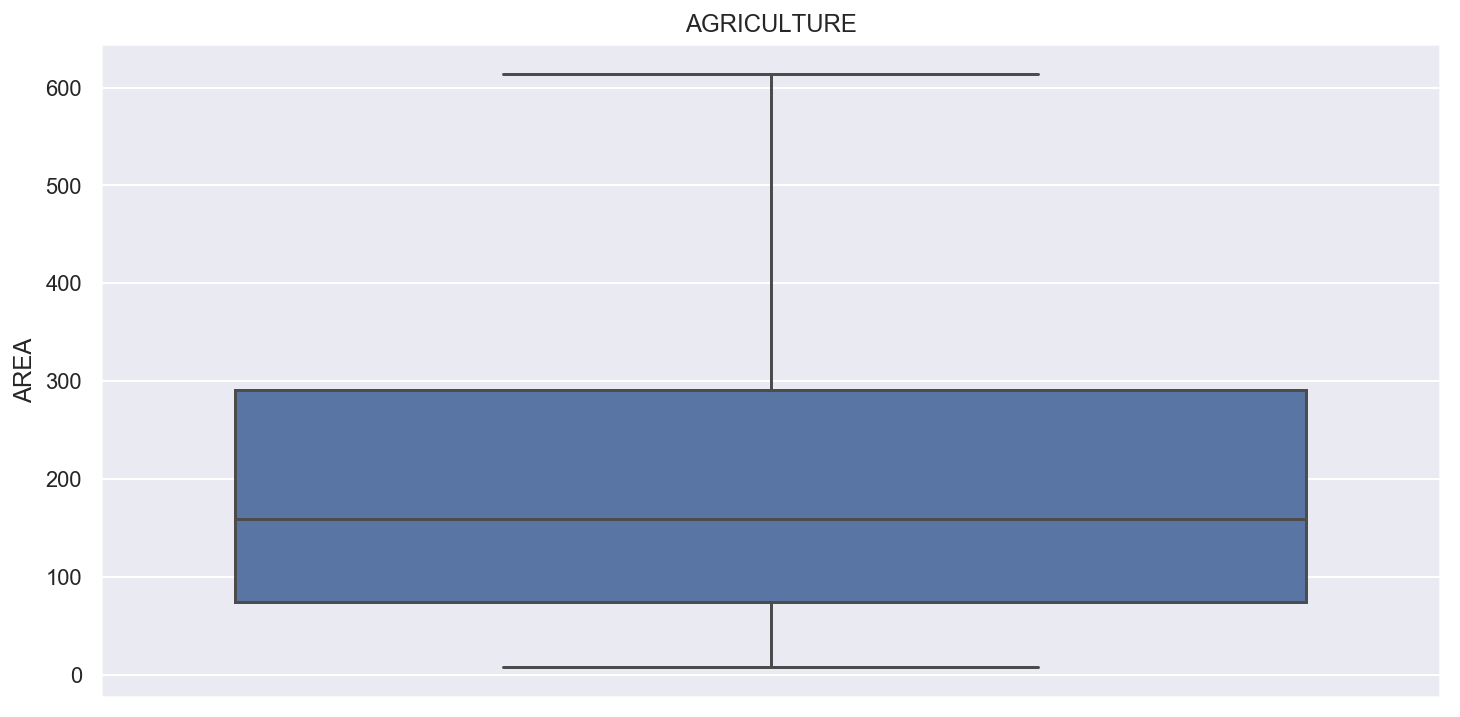

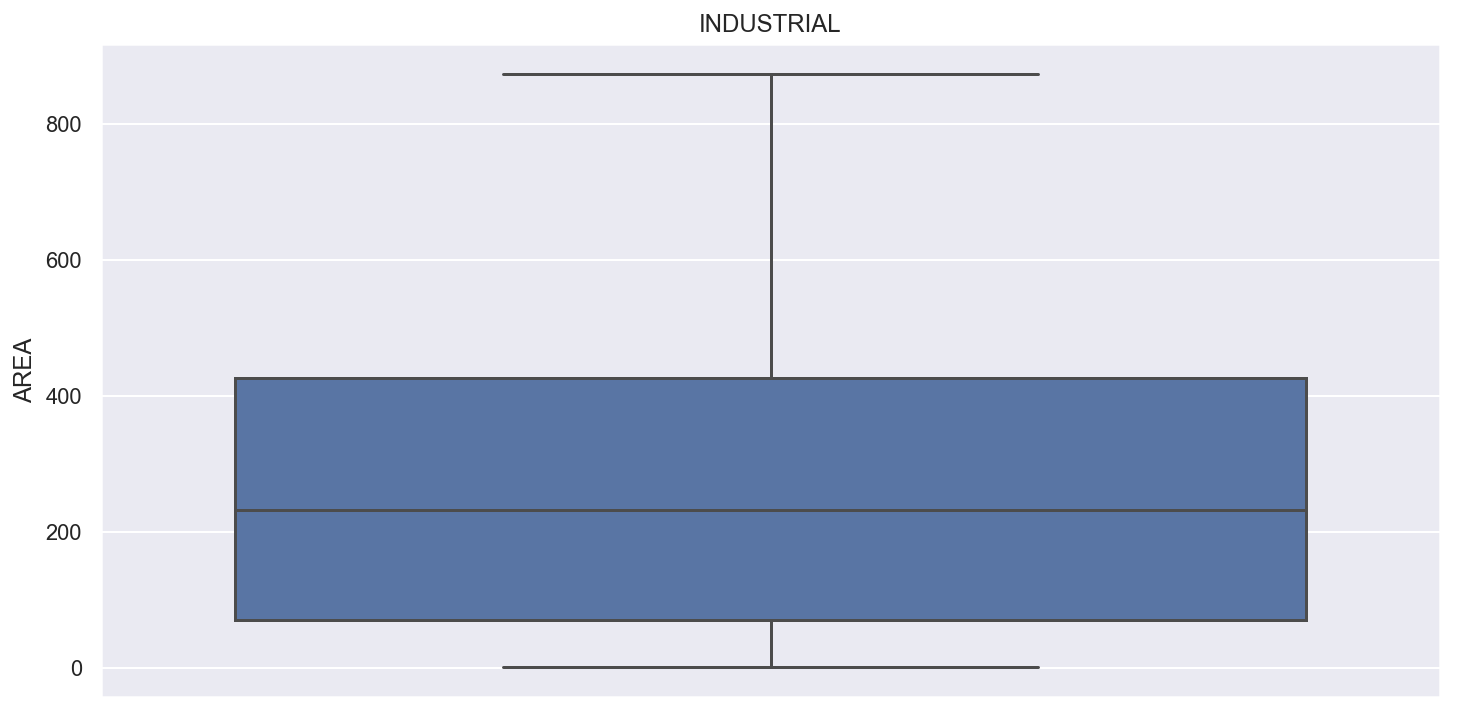

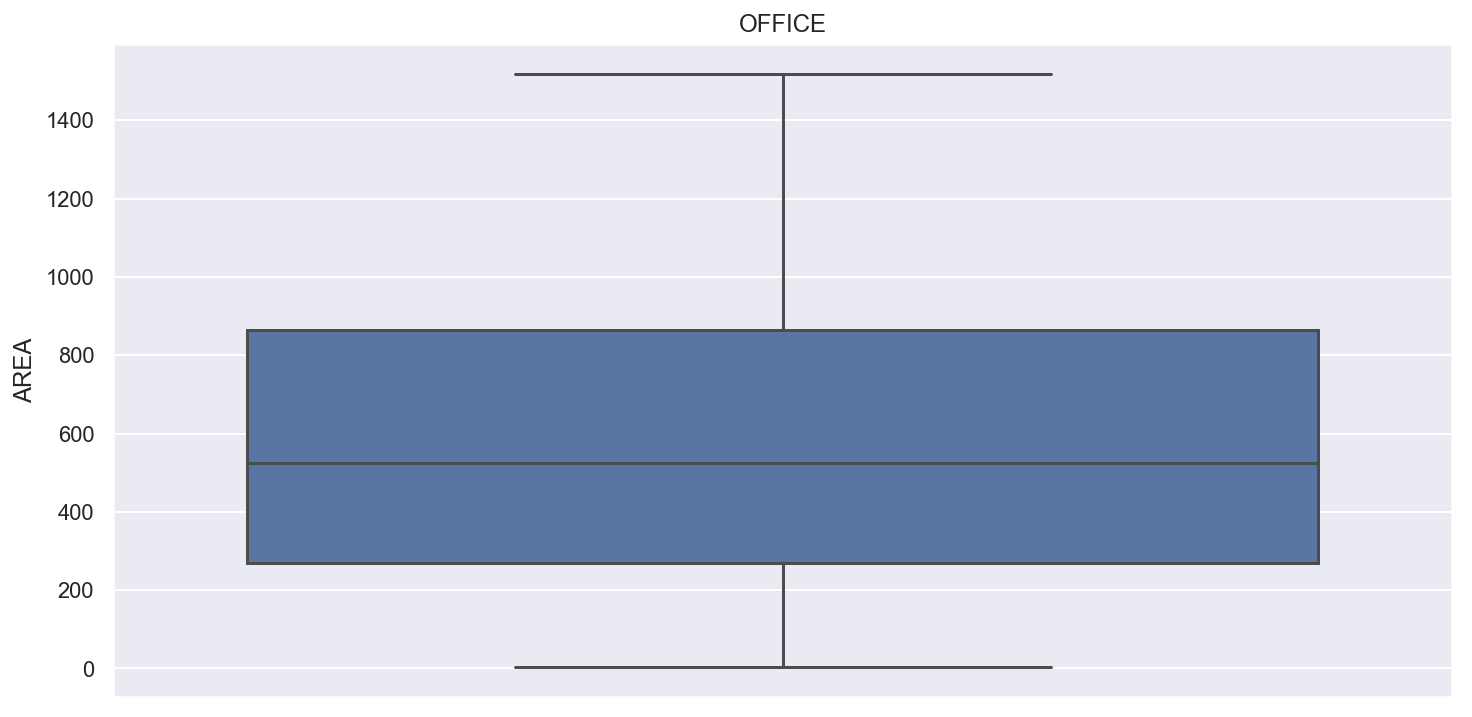

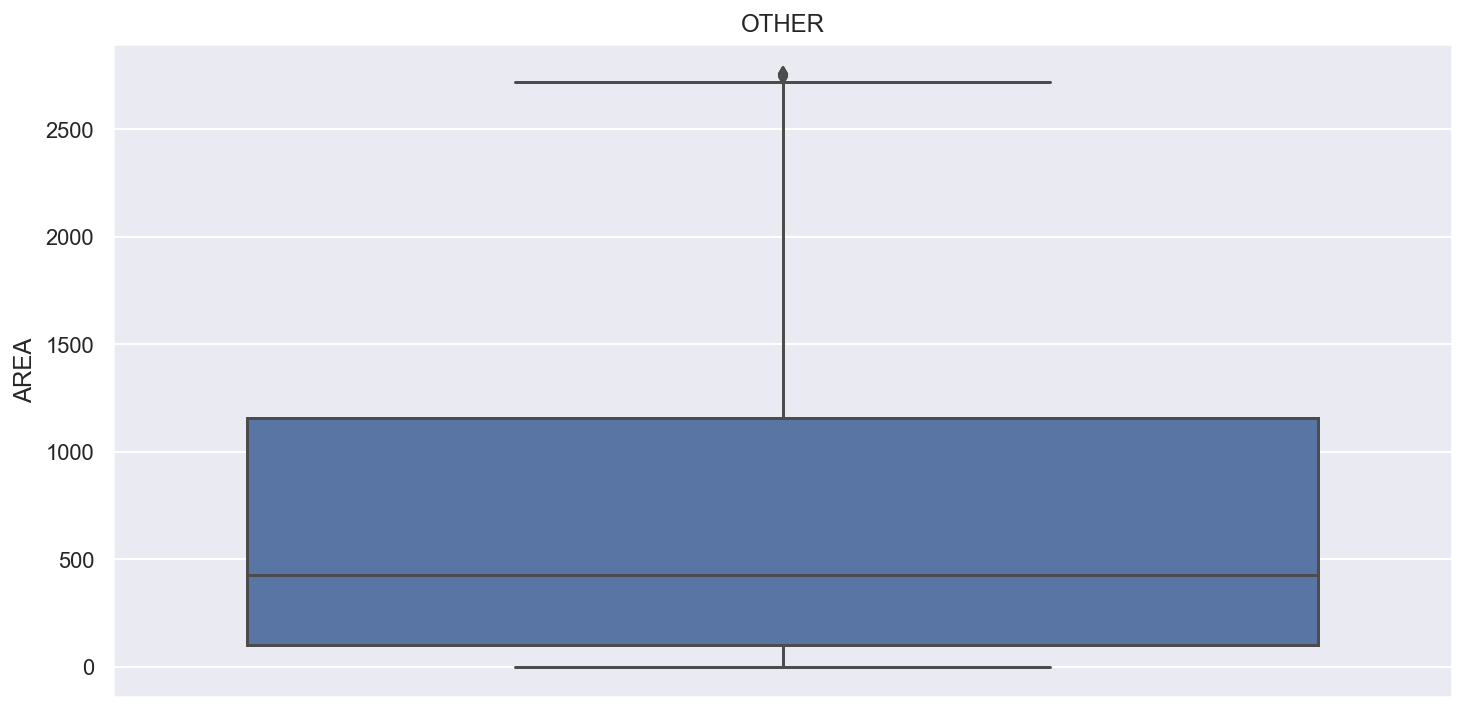

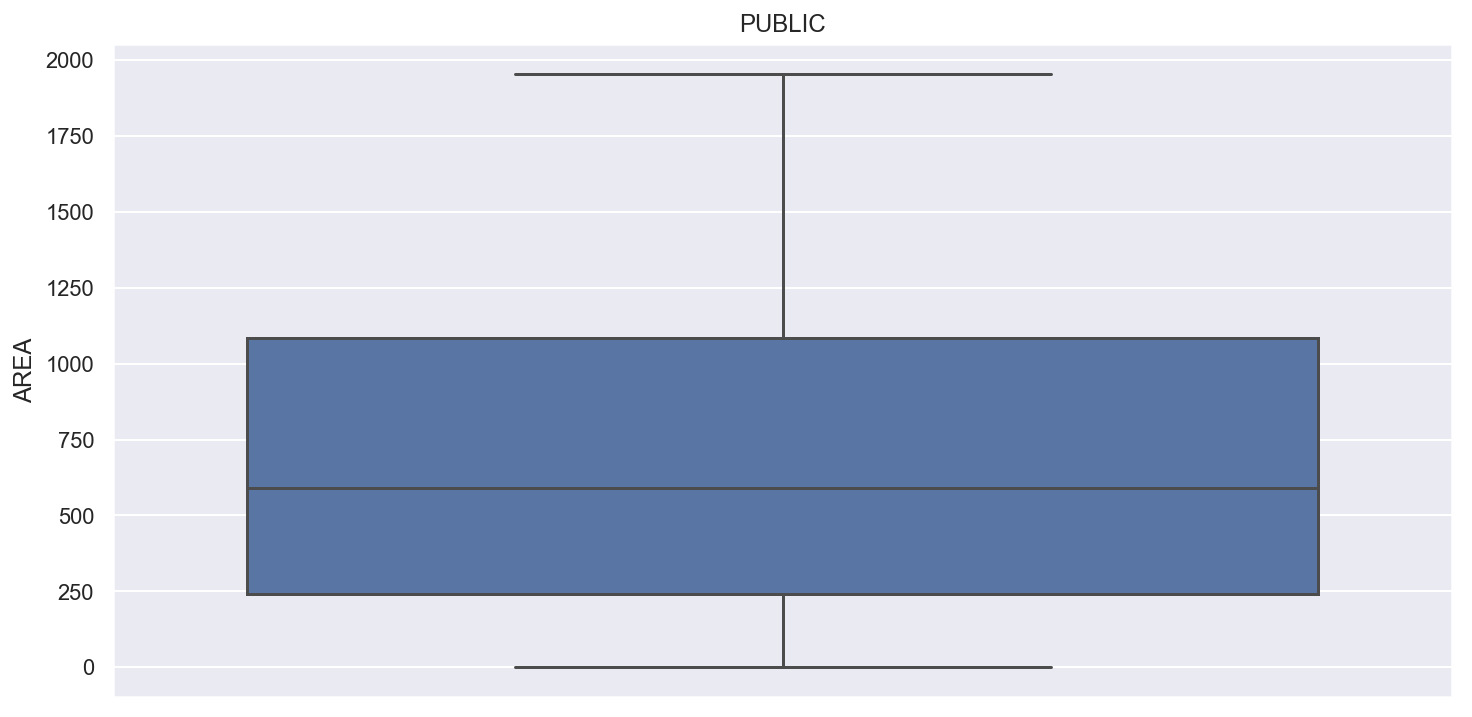

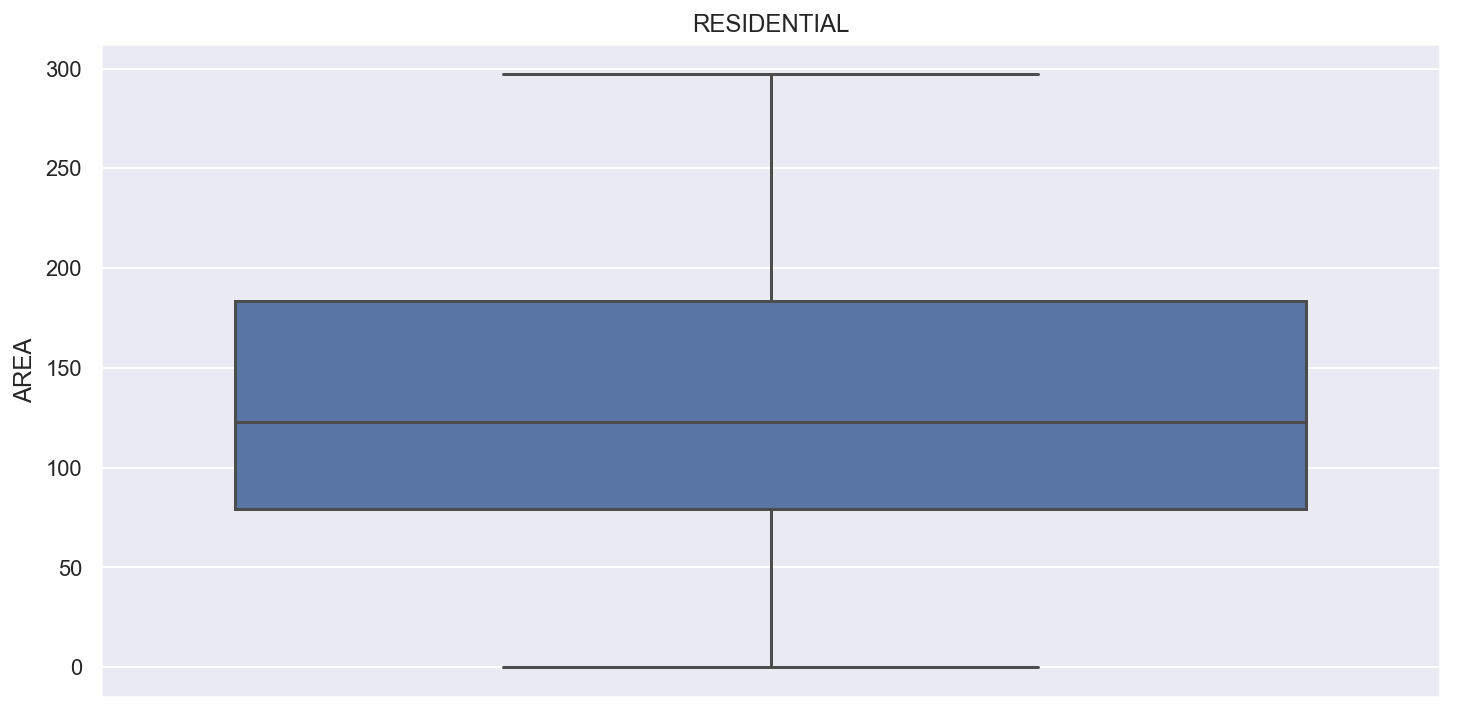

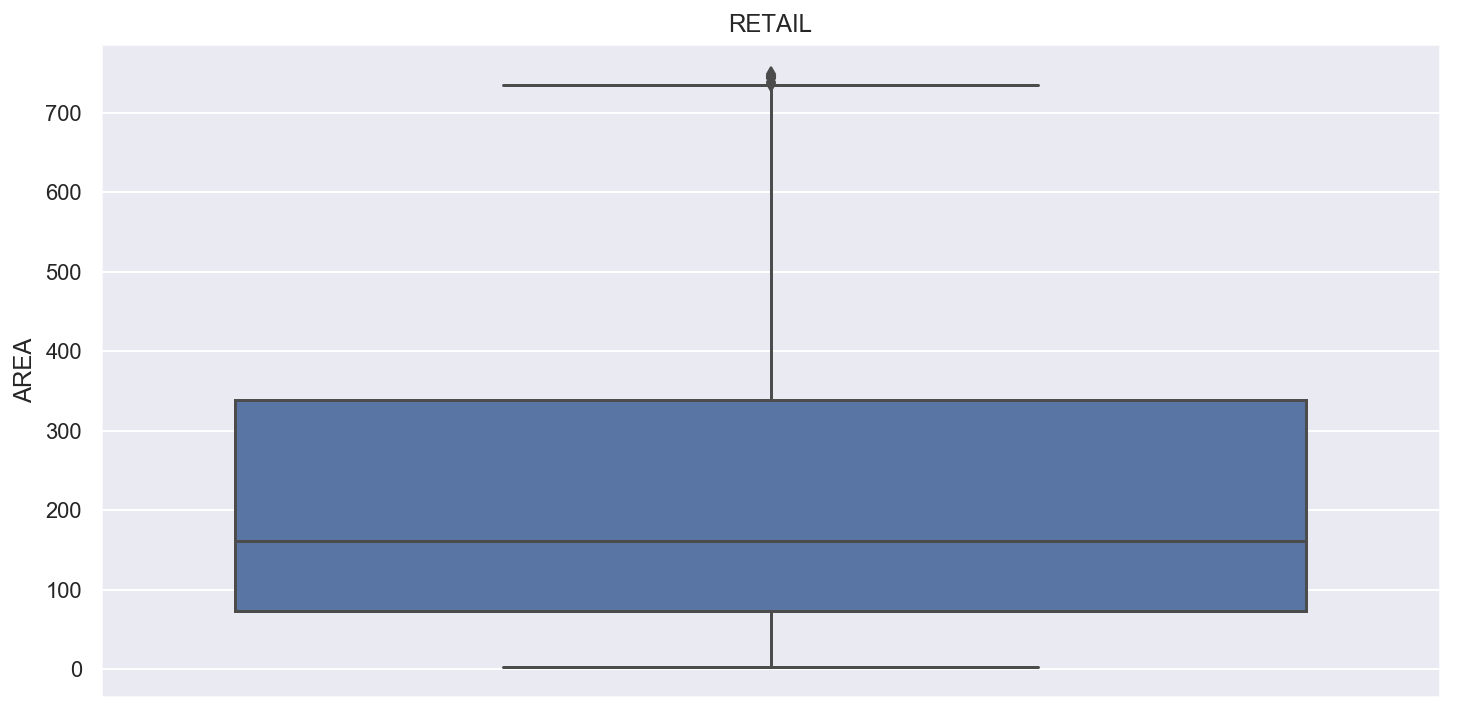

In [24]:
data = df_aux_without_outliers.groupby('CLASE')
for name, group in data:
    plt.figure(figsize=(12,6))
    sns.boxplot(group['AREA'], orient='vertical')
    plt.title(name)

In [25]:
df_modelar = df_aux_without_outliers.copy()

In [26]:
print("\nPasos de preprocesamiento: ")
for step, function in enumerate(list_preprocess_function):
    print("\t {:d}: {:s}".format(step, function.__name__))


Pasos de preprocesamiento: 
	 0: process_distance_to_center
	 1: process_cadastral
	 2: process_neihgbours


In [27]:
df_modelar = preprocess_data(df_modelar, list_preprocess_function)

In [28]:
df_modelar.head()

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,CLASE,mean_red,mean_green,mean_blue,mean_nir,std_red,std_green,std_blue,std_nir,distance_to_center
ID,,,,,,,,,,,,,,,,,,,,,
306803655F285386,2228093971,165649561,0.00000,388.001147,584.004370,743.997858,891.000598,1042.505188,1201.999268,1378.998694,...,RESIDENTIAL,1826.737524,1585.798107,777.858129,2265.177079,2858.908036,2747.474068,696.885778,2960.096492,0.218601
580642E08F1D7033,2220083712,165808313,0.00000,326.004053,514.001172,671.001691,819.998169,963.002045,1110.996777,1276.998474,...,RESIDENTIAL,1290.327332,1196.175715,669.342316,1919.179675,1400.319461,1519.515626,455.411465,1527.577626,0.127689
FABA82816B5A558C,2177306019,165450233,0.00000,230.000186,378.405115,523.001740,646.000208,773.012451,915.998193,1080.996216,...,RESIDENTIAL,1175.816700,1081.749046,554.363392,1949.421110,1488.352764,1491.766049,345.091585,1579.860295,0.357959
9E99E9965AED7767,2217514527,165388673,0.00000,499.700449,678.003564,806.003247,922.999207,1040.998291,1162.994458,1308.004126,...,RESIDENTIAL,1464.270817,1283.405690,684.573903,1919.016016,1706.047880,1751.523293,480.120841,1667.133138,0.098528
353B67F8CD4EED73,2226539021,165368964,0.00002,778.999207,960.998657,1105.999939,1247.002563,1404.001709,1576.000854,1767.000549,...,INDUSTRIAL,1805.353913,1607.053381,957.884245,2462.941343,1734.937082,1655.862399,644.900447,1639.235546,0.200964


# Ojo que el dataframe devuelto del procesamiento no está bien

In [ ]:
number_df_columns = df_modelar.select_dtypes(include=np.number).columns.tolist()

print('\n- \033[1mVariables numéricas\033[0m: ',number_df_columns)

In [ ]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
                             ('scaler', StandardScaler())])

In [ ]:
#Transformación que se le aplicaría a las columnas categóricas, en el caso de que existan
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_modelar_trans = ColumnTransformer(transformers=[('num', num_transformer, number_df_columns)])

### Modelo Binario

In [ ]:
df_modelar['SUBCLASE'] = (df_modelar['CLASE'] == 'RESIDENTIAL').astype(int)

In [ ]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_modelar.drop(columns=['CLASE', 'SUBCLASE']).copy()
y = df_modelar['SUBCLASE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [ ]:
rfc_p_model = xgb.XGBClassifier(random_state=10)
underSampling = RandomUnderSampler('majority', random_state=10)
smote = SMOTE('auto', random_state=10)

parameters = {
    'clas__max_depth': [10]
}

minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('smt', smote), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

In [ ]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
show_results(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [ ]:
importances = minsait_pipe_rfc_p['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [ ]:
pickle.dump(minsait_pipe_rfc_p, open('/content/drive/My Drive/binary_xgboost_MBM.model', 'wb'))

### Modelo Multietiqueta

In [ ]:
y_pred_train = minsait_pipe_rfc_p.predict(X_train)

In [ ]:
X_multi = df_modelar.loc[X_train[y_pred_train==0].index.tolist()].drop(columns=['CLASE', 'SUBCLASE']).copy()
y_multi = df_modelar.loc[X_train[y_pred_train==0].index.tolist()]['CLASE'].copy()

In [ ]:
y_multi.value_counts()

In [ ]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=10)
#smt = SMOTE('not majority', random_state=10)

In [ ]:
model = RandomForestClassifier(random_state=10)

parameters = {}
parameters['clas__max_depth'] = [5, 10, 20] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                            # Lo forzamos a ponerle profundidad, como máximo 20, aunque se podría establecer mayor profundidad pero no queremos que sobreajute a los datos del train.
parameters['clas__n_estimators'] = [100, 200]
parameters['clas__class_weight'] = ['balanced']

pipe = Pipeline(steps=[('prep', df_minsait_trans),('clas', model)])
GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train_multi, y_train_multi)
print(f"Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

model_multilabel = GS.best_estimator_

In [ ]:
y_pred_multi = model_multilabel.predict(X_test_multi)
print(classification_report(y_test_multi, y_pred_multi))

In [ ]:
importances = model_multilabel['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [ ]:
pickle.dump(model_multilabel, open('/content/drive/My Drive/multilabel_rfc_MBM.model', 'wb'))